In [1]:
import warnings 
warnings.filterwarnings('ignore')

In [2]:
import os 
from pathlib import Path 
from glob import glob 

import matplotlib 
from matplotlib import pyplot as plt 
import seaborn as sns 

import numpy as np
import scipy 
from scipy import stats 
import pandas as pd
import itertools

In [3]:
plt.rcParams["font.family"] = "times" # "helvetica"
plt.rcParams['axes.autolimit_mode'] = 'round_numbers'


In [4]:
import textwrap
def wrap_labels(ax, width, break_long_words=False):
    labels = []
    for label in ax.get_xticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width,
                      break_long_words=break_long_words))
    ax.set_xticklabels(labels, rotation=0)


In [39]:
molecules = ("ethanolAA",)
engines = ("lammps-VU", "mcccs",)


# Colors
symbols = {}
symbols["cassandra"] = "o" 
symbols[ "mcccs"] = "^"
symbols["gomc"] = "s"
symbols["gromacs"] = "x" 
symbols[ "hoomd"] = "v" 
symbols[ "lammps-VU"] = "D"
#symbols[ "LAMMPS-UD"] = ">"

colors = {}
colors["cassandra"] = "#009392" #(23/256, 109/256, 156/256)
colors["mcccs"] = "#39B1B5" #(194/256, 135/256, 32/256)
colors["gomc"] = "#9CCB86" #(21/256, 138/256, 106/256)
colors["gromacs"] = "#E9E29C" #(186/256, 97/256, 26/256)
colors["hoomd"] = "#EEB479" #(193/256, 130/256, 181/256)
colors["lammps-VU"] = "#E88471" #(188/256, 146/256, 110/256)
colors["fix"] = "#FF7F00"
colors["flex"] = "#007FFF"
# colors_dict = {all_engine_molecule: all_engine_colors, 
#                pentane_fixed: pentane_fixed_colors,
#                pentane_flexible: pentane_flexible_colors}

pretty_names = {
    "mcccsflex": "MCCCS-MN-flex", 
    "mcccsfix": "MCCCS-MN-fix", 
    "lammps-VUflex": "LAMMPS-flex",
    "lammps-VUfix": "LAMMPS-fixOH",
}

fill_styles = {
    "mcccs": "none", 
    "lammps-VU": "full",
}
figsize = (9, 8)

In [40]:
mcccs_hbonds = list() 
for path in glob("../src/engines/mcccs/hbond_analysis_data/*"):
    mcccs_hbonds.append(Path(path))
    
lammps_hbonds = list()
for path in glob("../src/engines/lammps-VU/hbond_analysis_data/*"):
    lammps_hbonds.append(Path(path))
    
hbonds = dict((molecule, dict()) for molecule in molecules)
for lmp, mcccs in zip(sorted(mcccs_hbonds), sorted(lammps_hbonds)):
    lmp_meta = lmp.name.split("_")
    mcccs_meta= mcccs.name.split("_") 
    
    assert lmp_meta == mcccs_meta
    molecule = lmp_meta[0]
    bcond = "fix" if "NPT-fixOH" in lmp_meta[1] else "flex"
    sp = f"{lmp_meta[2]}" #f"{lmp_meta[2]}, {mcccs_meta[3]}"
        
    if sp != "400.0K":
        with open(f"{lmp.absolute()}/nhbond.txt") as f:
            lmp_hbond = np.loadtxt(f, unpack=True)    

        with open(f"{mcccs.absolute()}/nhbond.txt") as f:
            mcccs_hbond = np.loadtxt(f, unpack=True)    

        if sp not in hbonds[molecule]:
            hbonds[molecule][sp] = dict()

        hbonds[molecule][sp][bcond] ={"lammps-VU": lmp_hbond,
                                        "mcccs": mcccs_hbond}



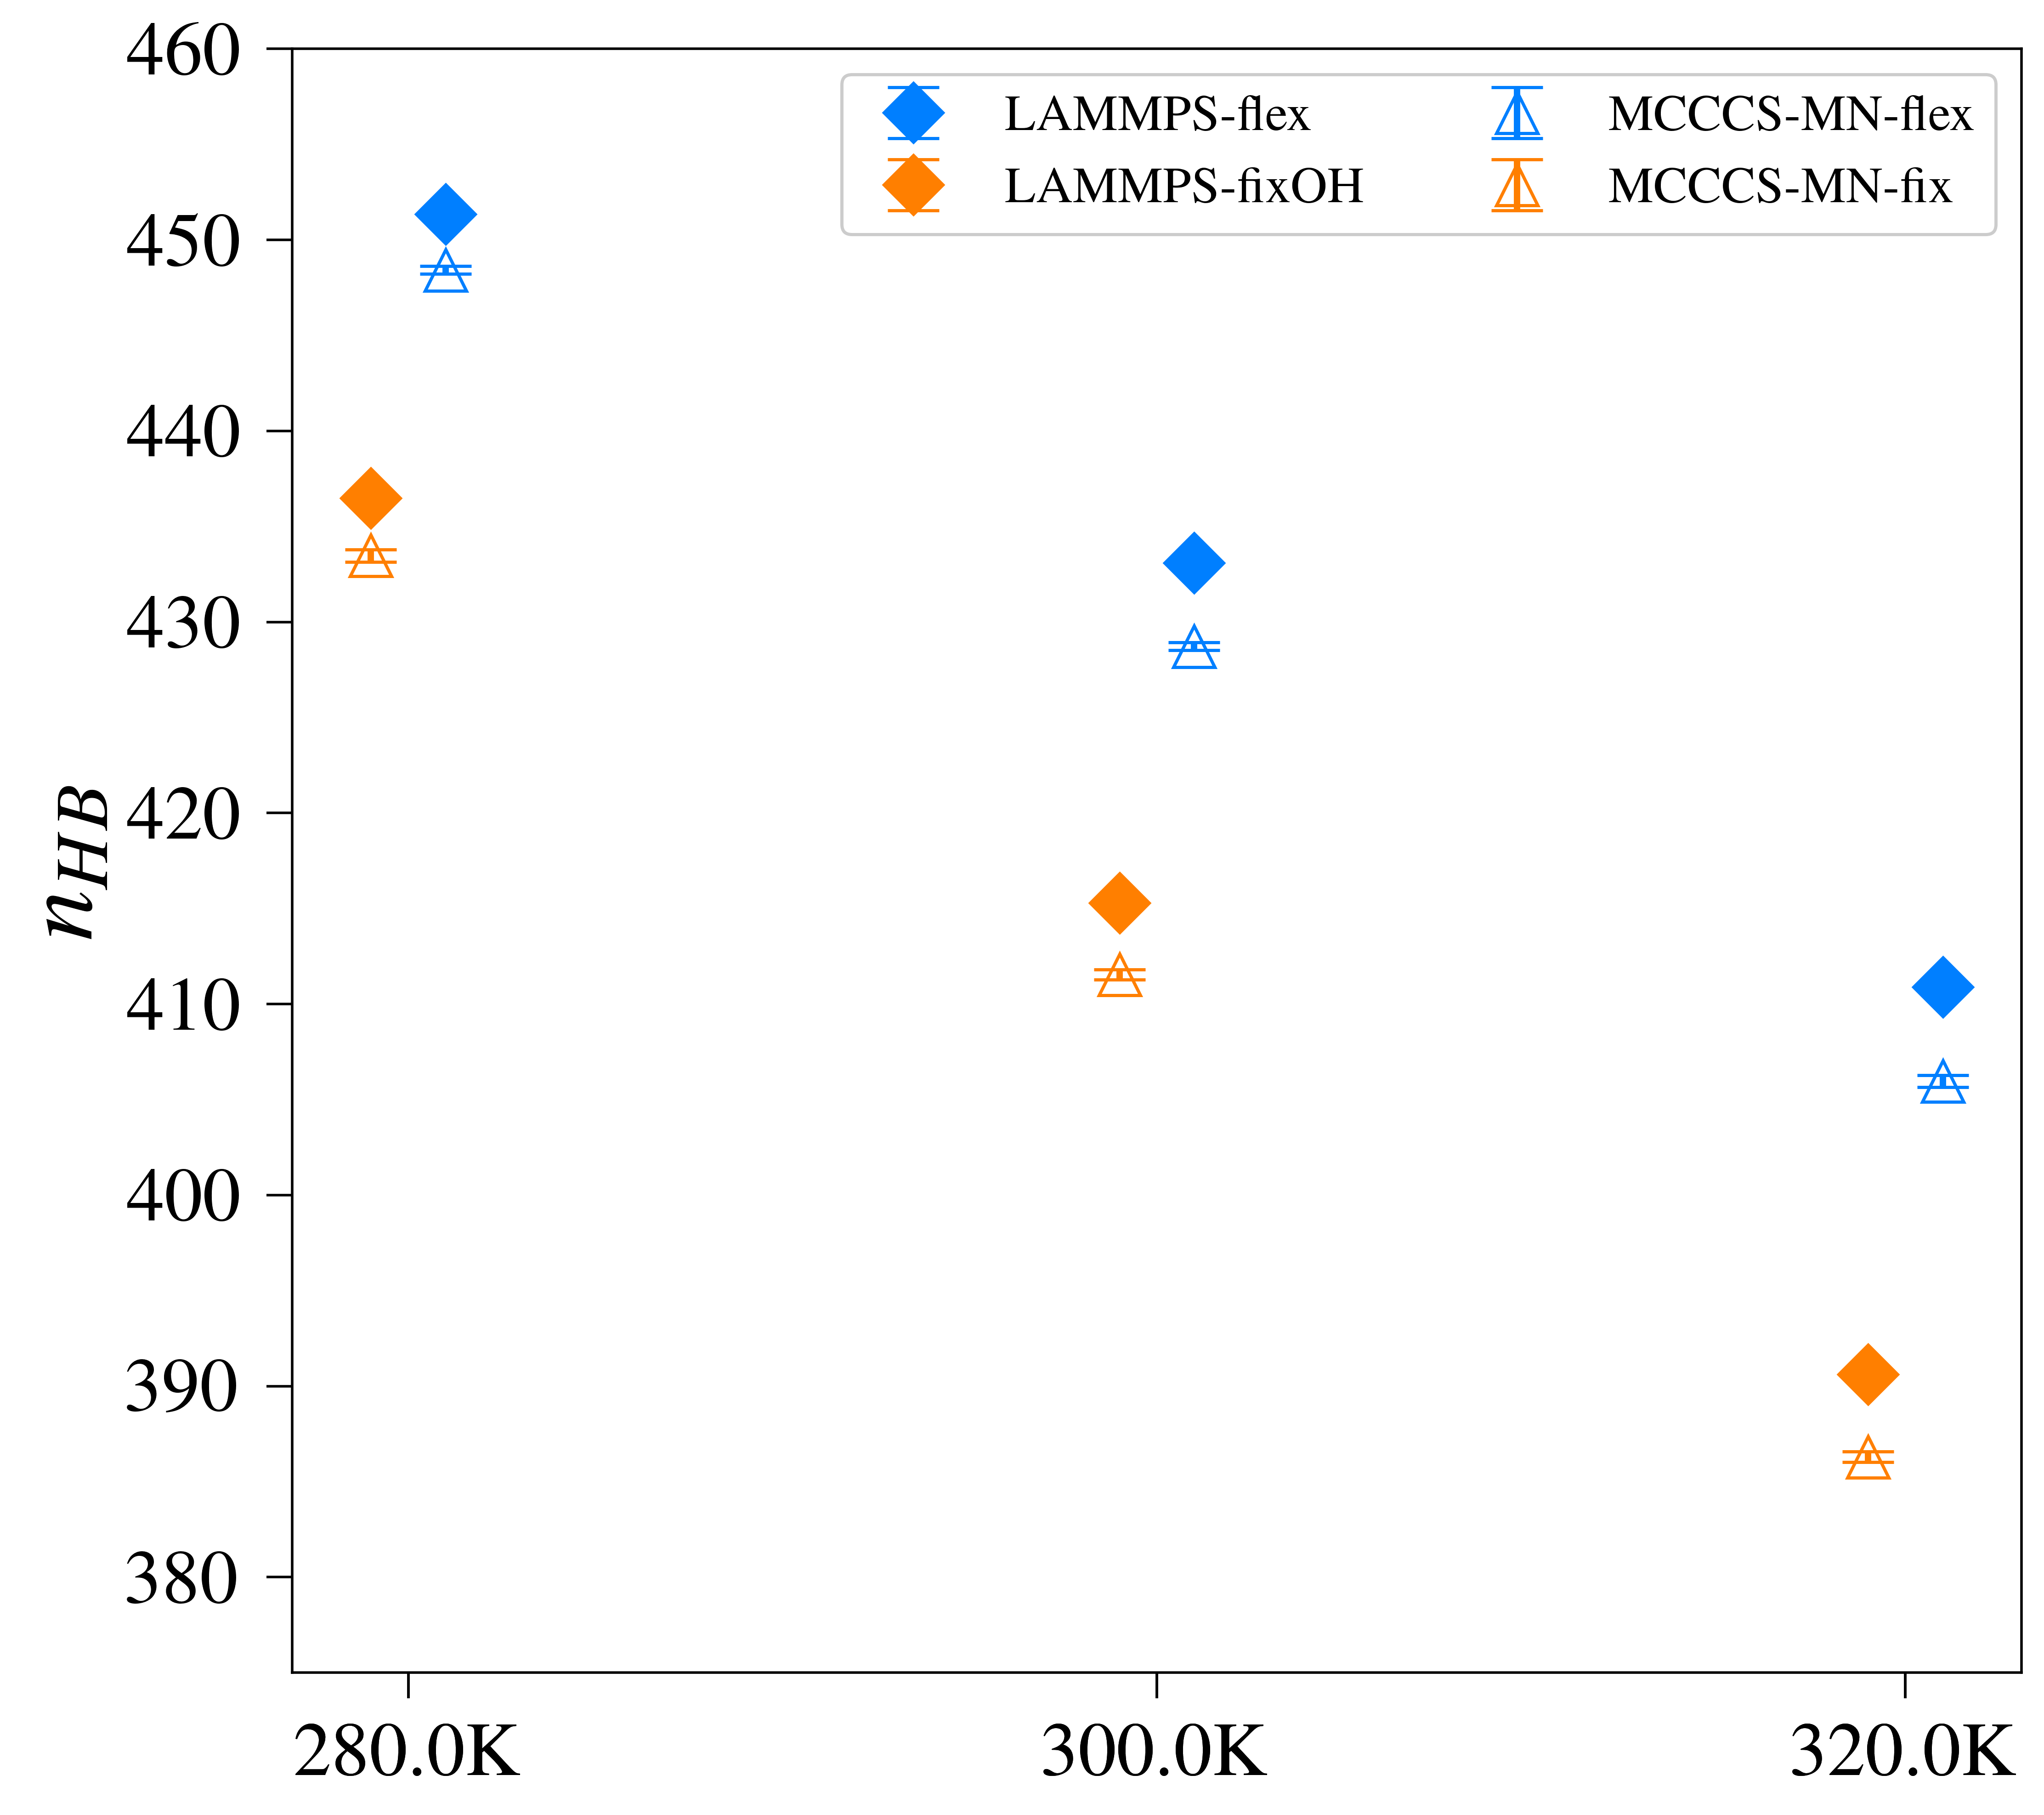

In [41]:
figsize = (9, 8)
fig, ax = plt.subplots(figsize=figsize)
#ax.minorticks_on()

molecule = "ethanolAA"

statepoints = sorted(set(hbonds[molecule]))
xticks = list()
sps_positions = list()
for n_sp, sp in enumerate(statepoints):
    sp_position = list()
    for engine in engines:
        for i, bcond in enumerate(["fix", "flex"]):
            try:
                ax.errorbar(
                    1*n_sp + 0.1*i, 
                    hbonds[molecule][sp][bcond][engine][0],
                    marker=symbols[engine], 
                    yerr=hbonds[molecule][sp][bcond][engine][1], 
                    color=colors[bcond], 
                    fillstyle=fill_styles[engine],
                    ls='',
                    label=engine+bcond,)
            except:
                continue
            sp_position.append(1*n_sp + 0.1*i,) 
        sps_positions.append(np.mean(sp_position))
        xticks.append(sp)


    # ax.set_xlabel("State point")
    ax.set_xticks([pos for pos in sps_positions]) 
    ax.set_xticklabels([
        sp for sp in xticks]
    )
    ax.set_ylabel("$n_{HB}$")
    wrap_labels(ax, 10)


# get handles
#wrap_labels(ax, 10)
handles, labels = ax.get_legend_handles_labels()

#Sorting handles and labels: 
labels_handles = dict()
for handle, label in zip(handles, labels):
    labels_handles[label] = handle

sorted_handles = [labels_handles[engine+bcond] 
                  for engine, bcond in itertools.product(engines, ["flex", "fix"])]
sorted_labels = [pretty_names[engine+bcond] 
                 for engine, bcond in itertools.product(engines, ["flex", "fix"])]

plt.legend(sorted_handles, 
           sorted_labels,
           facecolor='white', 
           loc ='best',
           ncol=2,
           prop={'size': 16}
          )
ax.set_ylim(375, 460)



# ax.tick_params(which='both', width=1)
# ax.tick_params(which="major", length=8, axis="y", bottom=False)
# ax.tick_params(which="minor", length=4, axis="y", bottom=False)
# ax.minorticks_on()
# ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))
# ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))
# ax.axes.xaxis.set_minor_locator(AutoMinorLocator())
# ax.axes.yaxis.set_minor_locator(AutoMinorLocator())

ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='minor',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    ) # labels along the bottom edge are off
ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='major',      # both major and minor ticks are affected
    length=8
    ) # labels along the bottom edge are off

ax.tick_params(
    axis='y',          # changes apply to the y-axis
    which='minor',      # both major and minor ticks are affected
    length=4,
    ) # labels along the bottom edge are off
ax.tick_params(
    axis='y',          # changes apply to the x-axis
    which='major',      # both major and minor ticks are affected
    length=8
    ) # labels along the bottom edge are off


plt.tight_layout()
plt.grid(alpha = 0., axis='x')

plt.savefig(f"figures/ethanol_hbonds.pdf", dpi=500)
plt.show()